Slab Subduction
======

This two dimensional subduction model has a dense, high viscosity 3 layered plate overlying a lower viscosity mantle. The upper and lower plate layers have a visco-plastic rheology, yielding under large stresses. The middle, core layer has a viscous only rheology, maintaining strength during bending. The top 1000 km of the mantle is included, the upper & lower mantle is partitioned with a viscosity contrast of 100x at 600 km depth. The velocity boundary conditions on the domain are period side, free-slip top and no-slip bottom wall. 

**References**

1. OzBench, M.; Regenauer-Lieb, K.; Stegman, D. R.; Morra, G.; Farrington, R.; Hale, A.; May, D. A.; Freeman, J.; Bourgouin, L.; Mühlhaus, H. & Moresi, L. A model comparison study of large-scale mantle-lithosphere dynamics driven by subduction. Physics of the Earth and Planetary Interiors, 2008, 171, 224-234. [OzBench, 2008](http://www.sciencedirect.com/science/article/pii/S0031920108002318)

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer
import numpy as np
import os

In [2]:
outputPath = os.path.join(os.path.abspath("."),"SlabSubduction/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

**Setup parameters**


In [3]:
xRes = 192  
yRes =  48
dim  = 2
boxLength = 4.0
boxHeight = 1.0

**Create mesh and finite element variables**

In [4]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes, yRes), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight),
                                 periodic    = [True, False] ) 

velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

**Create a particle swarm**

In [5]:
swarm = uw.swarm.Swarm( mesh=mesh )
materialVariable   = swarm.add_variable( dataType="int", count=1 )
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

**Allocate materials to particles**

In [6]:
# initialise the 'materialVariable' data to represent two different materials. 
upperMantleIndex = 0
lowerMantleIndex = 1
upperSlabIndex   = 2
lowerSlabIndex   = 3
coreSlabIndex    = 4

# Initial material layout has a flat lying slab with at 15\degree perturbation
lowerMantleY   = 0.4
slabLowerShape = np.array([ (1.2,0.925 ), (3.25,0.925 ), (3.20,0.900), (1.2,0.900), (1.02,0.825), (1.02,0.850) ])
slabCoreShape  = np.array([ (1.2,0.975 ), (3.35,0.975 ), (3.25,0.925), (1.2,0.925), (1.02,0.850), (1.02,0.900) ])
slabUpperShape = np.array([ (1.2,1.000 ), (3.40,1.000 ), (3.35,0.975), (1.2,0.975), (1.02,0.900), (1.02,0.925) ])

slabLower = fn.shape.Polygon( slabLowerShape )
slabUpper = fn.shape.Polygon( slabUpperShape )
slabCore  = fn.shape.Polygon( slabCoreShape )

# initialise everying to be upper mantle material
materialVariable.data[:] = upperMantleIndex

# change matieral index if the particle is not upper mantle
for index in range( len(swarm.particleCoordinates.data) ):
    coord = swarm.particleCoordinates.data[index][:]
    if coord[1] < lowerMantleY:
        materialVariable.data[index]     = lowerMantleIndex
    if slabCore.evaluate(tuple(coord)):
            materialVariable.data[index] = coreSlabIndex
    if slabUpper.evaluate(tuple(coord)):
            materialVariable.data[index] = upperSlabIndex
    elif slabLower.evaluate(tuple(coord)):
            materialVariable.data[index] = lowerSlabIndex

**Plot the initial positions for the particle swarm and colour by material type**

We are using a vis store object to keep all our figures together and allow them to be revisualised later so create this here and pass it to all the figures created later. We'll also name this figure to make it easy to find later when revisualising.


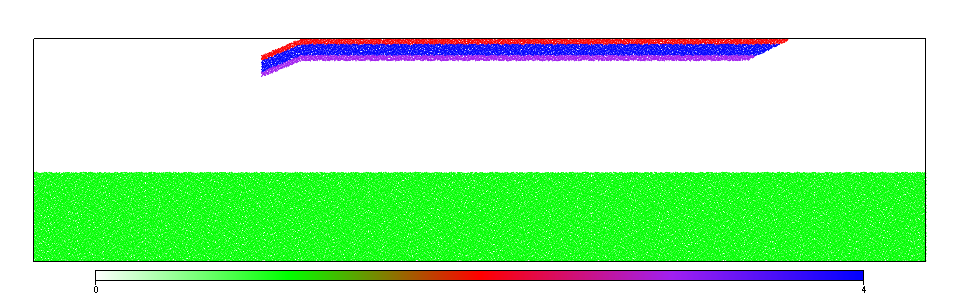

In [7]:
store = glucifer.Store('subduction')
figParticle = glucifer.Figure( store, figsize=(960,300), name="Particles" )
figParticle.append( glucifer.objects.Points(swarm, materialVariable, pointSize=2, colours='white green red purple blue') )
figParticle.show()

Set up material parameters and functions
----

Here the functions for density, viscosity, gravity and buoyancy are set. 

**Viscosity function**

The lower mantle is 100x more viscous than the upper mantle. 
The upper and lower slab layer weakens under high strain, it has a visco plastic rheology.  
The lower slab layer does not yield, it has a viscous rheology.  

In [8]:
upperMantleViscosity =    1.0
lowerMantleViscosity =  100.0
slabViscosity        =  500.0
coreViscosity        =  500.0

# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))
cohesion = 0.06
vonMises = 0.5 * cohesion / (strainRate_2ndInvariant+1.0e-18)

# The upper slab viscosity is the minimum of the 'slabViscosity' or the 'vonMises' 
slabYieldvisc = fn.exception.SafeMaths( fn.misc.min(vonMises, slabViscosity) )

# Viscosity function for the materials 
viscosityMap = { upperMantleIndex : upperMantleViscosity, 
                 lowerMantleIndex : lowerMantleViscosity, 
                 upperSlabIndex   : slabYieldvisc, 
                 lowerSlabIndex   : slabYieldvisc,
                 coreSlabIndex    : coreViscosity}
viscosityMapFn = fn.branching.map( fn_key = materialVariable, mapping = viscosityMap )

Note: ``SafeMaths`` in the above cell refers to a function which checks the value passed inside for any infinite or other not-a-number type errors.

**Set the density function, vertical unit vector and Buoyancy Force function**


In [9]:
mantleDensity = 0.0
slabDensity   = 1.0 

densityMap = { upperMantleIndex : mantleDensity, 
               lowerMantleIndex : mantleDensity, 
               upperSlabIndex   : slabDensity, 
               lowerSlabIndex   : slabDensity, 
               coreSlabIndex    : slabDensity}
densityFn = fn.branching.map( fn_key = materialVariable, mapping = densityMap )

# Define our vertical unit vector using a python tuple
z_hat = ( 0.0, 1.0 )

# now create a buoyancy force vector
buoyancyFn = -1.0 * densityFn * z_hat

**Set initial and boundary conditions**

In [10]:
# set initial conditions (and boundary values)
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

# send boundary condition information to underworld
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MinJ_VertexSet"]

periodicBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = ( bottomWall, jWalls) ) 


**System Setup**

In [11]:
# Initial linear slab viscosity setup
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               voronoi_swarm = swarm, 
                               conditions    = [periodicBC,],
                               fn_viscosity  = viscosityMapFn, 
                               fn_bodyforce  = buoyancyFn )
# Create solver & solve
solver = uw.systems.Solver(stokes)

In [12]:
# use "lu" direct solve if running in serial
if(uw.nProcs()==1):
    solver.set_inner_method("lu")

In [13]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

**Analysis tools**

In [14]:
#The root mean square Velocity
velSquared = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )
area = uw.utils.Integral( 1., mesh )
Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )

In [15]:
#Plot of Velocity Magnitude
figVelocityMag = glucifer.Figure(store, figsize=(960,300))
figVelocityMag.append( glucifer.objects.Surface(mesh, fn.math.sqrt(fn.math.dot(velocityField,velocityField))) )

#Plot of Strain Rate, 2nd Invariant
figStrainRate = glucifer.Figure(store, figsize=(960,300))
figStrainRate.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True) )

#Plot of particles viscosity
figViscosity = glucifer.Figure(store, figsize=(960,300))
figViscosity.append( glucifer.objects.Points(swarm, viscosityMapFn, pointSize=2) )

#Plot of particles stress invariant
figStress = glucifer.Figure( store, figsize=(960,300) )
figStress.append( glucifer.objects.Points(swarm, 2.0*viscosityMapFn*strainRate_2ndInvariant, pointSize=2, logScale=True) )

Main simulation loop
=======

The main time stepping loop begins here. Inside the time loop the velocity field is solved for via the Stokes system solver and then the swarm is advected using the advector integrator. Basic statistics are output to screen each timestep.

In [ ]:
time = 0.  # Initial time
step = 0   # Initial timestep
maxSteps = 3      # Maximum timesteps (201 is recommended)
steps_output = 10   # output every 10 timesteps

In [ ]:
while step < maxSteps:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True)
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        #Important to set the timestep for the store object here or will overwrite previous step
        store.step = step
        figParticle.save(    outputPath + "particle"    + str(step).zfill(4))
        figVelocityMag.save( outputPath + "velocityMag" + str(step).zfill(4))
        figStrainRate.save(  outputPath + "strainRate"  + str(step).zfill(4))
        figViscosity.save(   outputPath + "viscosity"   + str(step).zfill(4))
        figStress.save(      outputPath + "stress"      + str(step).zfill(4))
        
        Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
        print 'step = {0:6d}; time = {1:.3e}; Vrms = {2:.3e}'.format(step,time,Vrms)

    dt = advector.get_max_dt()
    advector.integrate(dt)
    time += dt
    step += 1

Post simulation analysis
-----

Plot all figures for the resulting system using the Viewer class to load the saved visualisation.
This allows us to open a previously saved visualisation database, just pass the same name used when creating the Store object

In [ ]:
import glucifer
saved = glucifer.Viewer('subduction')

Here we print some information about the loaded visualisation which shows what data is available
(as we only gave our first figure a name "Particles" the others have been automatically named)

In [ ]:
print "Saved database '%s'" % (saved._db.filename)
print " - %d figures : %s" % (len(saved), list(saved))
print " - %d timesteps (final = %d) : %s" % (len(saved.steps), saved.steps[-1], saved.steps)

We just want to look at the final state of the simulation, so set the timestep to the last one in the list and loop through all the figures, plotting each one

In [ ]:
#Re-visualise the final timestep
saved.step = saved.steps[-1]
for name in saved:
    fig = saved[name]
    fig.quality = 2
    fig.properties["title"] = "Timestep ##"
    fig.show()